In [1]:
import sys, os
sys.path += ["../../"]

In [2]:
%load_ext autoreload
%autoreload 1
%aimport zero_order_gpmpc

In [3]:
import numpy as np
from scipy.stats import norm
import casadi as cas
from acados_template import AcadosOcp, AcadosSim, AcadosSimSolver, AcadosOcpSolver, AcadosOcpOptions
import matplotlib.pyplot as plt
import torch
import gpytorch
import copy

# zoRO imports
import zero_order_gpmpc
from zero_order_gpmpc import ZoroAcados, ZoroAcadosCustomUpdate, ZeroOrderGPMPC
from inverted_pendulum_model_acados import export_simplependulum_ode_model, export_ocp_nominal
from utils import base_plot, add_plot_trajectory, EllipsoidTubeData2D

# gpytorch_utils
from gpytorch_utils.gp_hyperparam_training import generate_train_inputs_acados, generate_train_outputs_at_inputs, train_gp_model
from gpytorch_utils.gp_utils import gp_data_from_model_and_path, gp_derivative_data_from_model_and_path, plot_gp_data, generate_grid_points
from gpytorch_utils.gp_model import MultitaskGPModel, BatchIndependentMultitaskGPModel


## Define model parameters

We model the inverted pendulum

$$
\dot{x} = f(x,u) = \begin{bmatrix} \dot{\theta} \\ \ddot{\theta} \end{bmatrix} = \begin{bmatrix} \dot{\theta} \\ -\sin(\theta) + u \end{bmatrix},
$$

which is to be controlled from the hanging-down resting position, $(\theta_0, \dot{\theta}_0) = (\pi, 0)$, to the upright position ($(\theta_r, \dot{\theta}_r) = (0,0)$), subject to the constraints that overshoot should be avoided, i.e.,

$$
\theta_{lb} \leq \theta \leq \theta_{ub}.
$$

The model setup and controller definition can be found in the functions `export_simplependulum_ode_model()`, `export_ocp_nominal()` in the `inverted_pendulum_model_acados.py` file.

In [4]:
# build C code again?
build_c_code = True

In [5]:
# discretization
N = 30
T = 5
dT = T / N

# constraints
x0 = np.array([np.pi, 0])
nx = 2
nu = 1


In [6]:
prob_x = 0.9
prob_tighten = norm.ppf(prob_x)

# noise
# uncertainty dynamics
sigma_theta = (0.0001/360.) * 2 * np.pi
sigma_omega = (0.0001/360.) * 2 * np.pi
w_theta = 0.03
w_omega = 0.03
Sigma_x0 = np.array([
    [sigma_theta**2,0],
    [0,sigma_omega**2]
])
Sigma_W = np.array([
    [w_theta**2, 0],
    [0, w_omega**2]
])

## Set up nominal solver

In [7]:
ocp_init = export_ocp_nominal(N,T,only_lower_bounds=True)
ocp_init.solver_options.nlp_solver_type = "SQP"

acados_ocp_init_solver = AcadosOcpSolver(ocp_init, json_file="acados_ocp_init_simplependulum_ode.json")

rm -f libacados_ocp_solver_simplependulum_ode.so
rm -f simplependulum_ode_constraints/simplependulum_ode_constr_h_fun_jac_uxt_zt.o simplependulum_ode_constraints/simplependulum_ode_constr_h_fun.o acados_solver_simplependulum_ode.o
cc -fPIC -std=c99   -O2 -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include/acados -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include/blasfeo/include -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include/hpipm/include  -c -o simplependulum_ode_constraints/simplependulum_ode_constr_h_fun_jac_uxt_zt.o simplependulum_ode_constraints/simplependulum_ode_constr_h_fun_jac_uxt_zt.c
cc -fPIC -std=c99   -O2 -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include/acados -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include/blasfeo/include -I/home/amon/Repositories/zero-order-gp-

## Open-loop planning with nominal solver

In [8]:
# get initial values
X_init = np.zeros((N+1, nx))
U_init = np.zeros((N, nu))

# xcurrent = x0
X_init[0,:] = x0

# solve
status_init = acados_ocp_init_solver.solve()

if status_init != 0:
    raise Exception('acados acados_ocp_solver returned status {}. Exiting.'.format(status_init))

# get data
for i in range(N):
    X_init[i,:] = acados_ocp_init_solver.get(i, "x")
    U_init[i,:] = acados_ocp_init_solver.get(i, "u")

X_init[N,:] = acados_ocp_init_solver.get(N, "x")

In [9]:
import re

In [10]:
# integrator for nominal model
sim = AcadosSim()

sim.model = ocp_init.model
sim.parameter_values = ocp_init.parameter_values

for opt_name in dir(ocp_init.solver_options):
    if opt_name in dir(sim.solver_options) and re.search(r"__.*?__", opt_name) is None:
        if opt_name == "sim_method_jac_reuse":
            set_value = int(getattr(ocp_init.solver_options, opt_name)[0])
        else:
            set_value = getattr(ocp_init.solver_options, opt_name)
        print(f"Setting {opt_name} to {set_value}")
        setattr(sim.solver_options, opt_name, set_value)

sim.solver_options.T = ocp_init.solver_options.Tsim
acados_integrator = AcadosSimSolver(sim, json_file = 'acados_sim_' + sim.model.name + '.json')

Setting collocation_type to GAUSS_LEGENDRE
Setting ext_fun_compile_flags to -O2
Setting integrator_type to ERK
Setting sim_method_jac_reuse to 0


cc -fPIC -std=c99   -O2 -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include/acados -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include/blasfeo/include -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include/hpipm/include  -c -o acados_sim_solver_simplependulum_ode.o acados_sim_solver_simplependulum_ode.c
cc -fPIC -std=c99   -O2 -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include/acados -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include/blasfeo/include -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include/hpipm/include  -c -o simplependulum_ode_model/simplependulum_ode_expl_ode_fun.o simplependulum_ode_model/simplependulum_ode_expl_ode_fun.c
cc -fPIC -std=c99   -O2 -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include -I/home/amon/Repositories/zero-order-gp-mpc-github

## Simulator object

To automatically discretize the model (and obtain sensitivities of the discrete-time model) within the zero-order implementation, we create the `AcadosSimSolver` object to pass to the solver.

In [11]:
# generate training data for GP with augmented model
# "real model"
model_actual = export_simplependulum_ode_model()
model_actual.f_expl_expr = model_actual.f_expl_expr + cas.vertcat(
    cas.DM(0),
    -0.5*cas.sin((model_actual.x[0])**2)
)
model_actual.f_impl_expr = model_actual.xdot - model_actual.f_expl_expr
model_actual.name = model_actual.name + "_actual"

# acados integrator
sim_actual = AcadosSim()
sim_actual.model = model_actual
sim_actual.solver_options.integrator_type = "ERK"

# set prediction horizon
sim_actual.solver_options.T = dT

# acados_ocp_solver = AcadosOcpSolver(ocp, json_file = 'acados_ocp_' + model.name + '.json')
acados_integrator_actual = AcadosSimSolver(sim_actual, json_file = 'acados_sim_' + model_actual.name + '.json')

cc -fPIC -std=c99   -O2 -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include/acados -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include/blasfeo/include -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include/hpipm/include  -c -o acados_sim_solver_simplependulum_ode_actual.o acados_sim_solver_simplependulum_ode_actual.c
cc -fPIC -std=c99   -O2 -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include/acados -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include/blasfeo/include -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include/hpipm/include  -c -o simplependulum_ode_actual_model/simplependulum_ode_actual_expl_ode_fun.o simplependulum_ode_actual_model/simplependulum_ode_actual_expl_ode_fun.c
cc -fPIC -std=c99   -O2 -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include -I/home/

## Simulation results (nominal)

In [12]:
X_init_sim = np.zeros_like(X_init)
X_init_sim[0,:] = x0
for i in range(N):
    acados_integrator_actual.set("x", X_init_sim[i,:])
    acados_integrator_actual.set("u", U_init[i,:])
    acados_integrator_actual.solve()
    X_init_sim[i+1,:] = acados_integrator_actual.get("x")

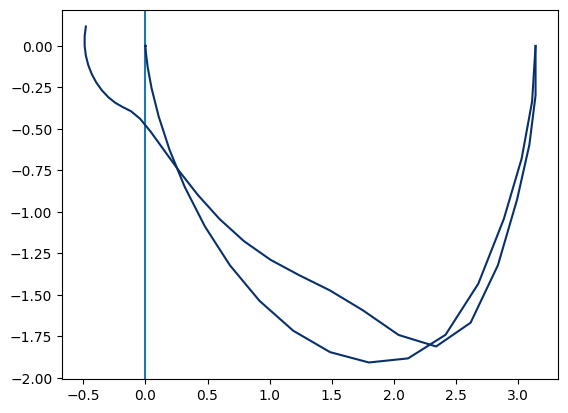

In [13]:
lb_theta = -ocp_init.constraints.lh[0]
fig, ax = base_plot(lb_theta=lb_theta)

plot_data_nom = EllipsoidTubeData2D(
    center_data = X_init,
    ellipsoid_data = None
)
plot_data_nom_sim = EllipsoidTubeData2D(
    center_data = X_init_sim,
    ellipsoid_data = None
)
add_plot_trajectory(ax, plot_data_nom, prob_tighten=None, color_fun=plt.cm.Blues)
add_plot_trajectory(ax, plot_data_nom_sim, prob_tighten=None, color_fun=plt.cm.Blues)

# GP training

We use a model with different parameters to emulate the real-world model and obtain some training data. Also create simulator object for real-world model to evaluate our results later (not used in solver).

## Generate training data

We generate training data (one-step ahead residuals `y_train` for starting point `x_train`) here by running robustified (cautious) solver without GP.

In [14]:
random_seed = 123
N_sim_per_x0 = 1
N_x0 = 10
x0_rand_scale = 0.1

x_train, x0_arr = generate_train_inputs_acados(
    acados_ocp_init_solver, 
    x0, 
    N_sim_per_x0, 
    N_x0, 
    random_seed=random_seed, 
    x0_rand_scale=x0_rand_scale
)

y_train = generate_train_outputs_at_inputs(
    x_train, 
    acados_integrator, 
    acados_integrator_actual, 
    Sigma_W
)

## Hyper-parameter training for GP model

Optimize hyper-parameters of GP model (kernel function parameters, ...)

In [15]:
x_train_tensor = torch.Tensor(x_train)
y_train_tensor = torch.Tensor(y_train)
nout = y_train.shape[1]

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(
    num_tasks = nout
)
gp_model = BatchIndependentMultitaskGPModel(x_train_tensor, y_train_tensor, likelihood, nout)

In [16]:
training_iterations = 200
rng_seed = 456

gp_model, likelihood = train_gp_model(gp_model, torch_seed=rng_seed, training_iterations=training_iterations)

# EVAL MODE
gp_model.eval()
likelihood.eval()

Iter 1/200 - Loss: 1.460
Iter 2/200 - Loss: 1.423
Iter 3/200 - Loss: 1.385
Iter 4/200 - Loss: 1.346
Iter 5/200 - Loss: 1.306
Iter 6/200 - Loss: 1.266
Iter 7/200 - Loss: 1.225
Iter 8/200 - Loss: 1.183
Iter 9/200 - Loss: 1.140
Iter 10/200 - Loss: 1.097
Iter 11/200 - Loss: 1.054
Iter 12/200 - Loss: 1.009
Iter 13/200 - Loss: 0.964
Iter 14/200 - Loss: 0.919
Iter 15/200 - Loss: 0.872
Iter 16/200 - Loss: 0.826
Iter 17/200 - Loss: 0.779
Iter 18/200 - Loss: 0.731
Iter 19/200 - Loss: 0.683
Iter 20/200 - Loss: 0.634
Iter 21/200 - Loss: 0.586
Iter 22/200 - Loss: 0.536
Iter 23/200 - Loss: 0.487
Iter 24/200 - Loss: 0.437
Iter 25/200 - Loss: 0.387
Iter 26/200 - Loss: 0.336
Iter 27/200 - Loss: 0.286
Iter 28/200 - Loss: 0.235
Iter 29/200 - Loss: 0.184
Iter 30/200 - Loss: 0.133
Iter 31/200 - Loss: 0.081
Iter 32/200 - Loss: 0.030
Iter 33/200 - Loss: -0.021
Iter 34/200 - Loss: -0.073
Iter 35/200 - Loss: -0.124
Iter 36/200 - Loss: -0.176
Iter 37/200 - Loss: -0.227
Iter 38/200 - Loss: -0.279
Iter 39/200 - L

MultitaskGaussianLikelihood(
  (raw_task_noises_constraint): GreaterThan(1.000E-04)
  (raw_noise_constraint): GreaterThan(1.000E-04)
)

## Plot GP predictions

We plot GP predictions along the predicted trajectory of the robustified solver by projecting the multivariate plot down to a line.

In [17]:
x_train.shape, y_train.shape

((300, 3), (300, 2))

(<Figure size 800x600 with 2 Axes>,
 array([<Axes: title={'center': 'Observed Values (Likelihood), output 0'}>,
        <Axes: title={'center': 'Observed Values (Likelihood), output 1'}>],
       dtype=object))

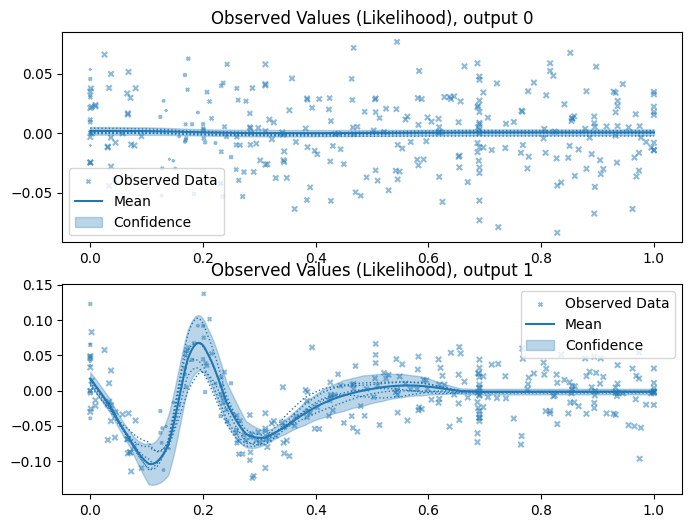

In [18]:
num_samples = 5
use_likelihood = False

num_points_between_samples = 30
t_lin = np.linspace(0,1,num_points_between_samples,endpoint=False)

x_plot_waypts = np.hstack((
    X_init[1:,:],
    U_init
)) 
x_plot = []
for i in range(x_plot_waypts.shape[0]-1):
    x_plot += [x_plot_waypts[i,:] + (x_plot_waypts[i+1,:] - x_plot_waypts[i,:]) * t for t in t_lin]
x_plot = np.vstack(x_plot)

gp_data = gp_data_from_model_and_path(gp_model, likelihood, x_plot, num_samples=num_samples, use_likelihood=use_likelihood)
plot_gp_data([gp_data], marker_size_lim=[1, 15])

We can also plot the derivative of the GP. Note that the projected Jacobian is not smooth since our path is not smooth either (jump projection direction = jump in Jacobian); however, the actual Jacobian should be smooth here (squared exponential kernel).

(<Figure size 800x600 with 2 Axes>,
 array([<Axes: title={'center': 'Observed Values (Likelihood), output 0'}>,
        <Axes: title={'center': 'Observed Values (Likelihood), output 1'}>],
       dtype=object))

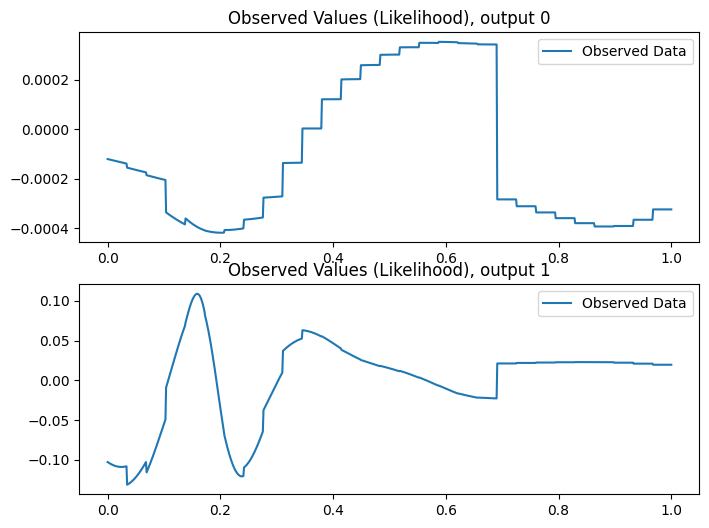

In [19]:
gp_derivative_data = gp_derivative_data_from_model_and_path(gp_model, likelihood, x_plot, num_samples=0)
plot_gp_data([gp_derivative_data], marker_size_lim=[5, 20], plot_train_data=False)

Compare with plotting along a slice of the dimension. Since we generated training data along the path of the robustified controller, the GP looks pretty untrained along a slice of the coordinates.

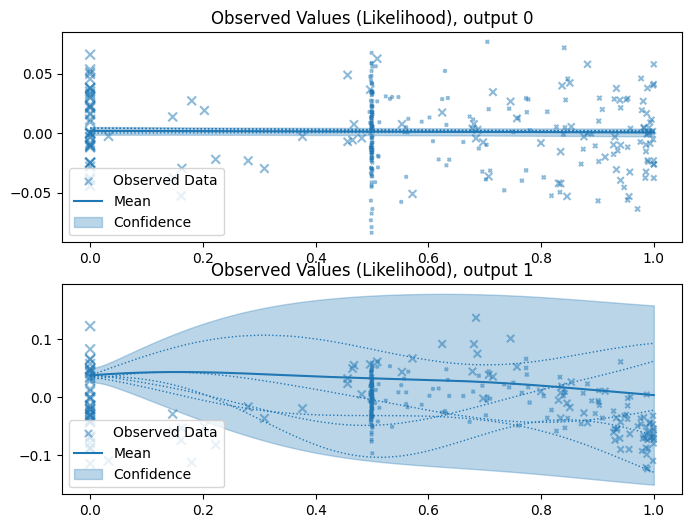

In [20]:
# plot along axis
x_dim_lims = np.array([
    [0, np.pi],
    [-2, 1],
    [-2, 2]
    ])
x_dim_slice = np.array([
    1 * np.pi,
    0,
    0
])
x_dim_plot = 2
x_grid = generate_grid_points(x_dim_lims, x_dim_slice, x_dim_plot, num_points=800)

gp_grid_data = gp_data_from_model_and_path(gp_model, likelihood, x_grid, num_samples=num_samples, use_likelihood=use_likelihood)
fig, ax = plot_gp_data([gp_grid_data], marker_size_lim=[5, 50])

y_lim_0 = ax[0].get_ylim()
y_lim_1 = ax[1].get_ylim()

Jacobian... not much going on away from the data points (this is good!)

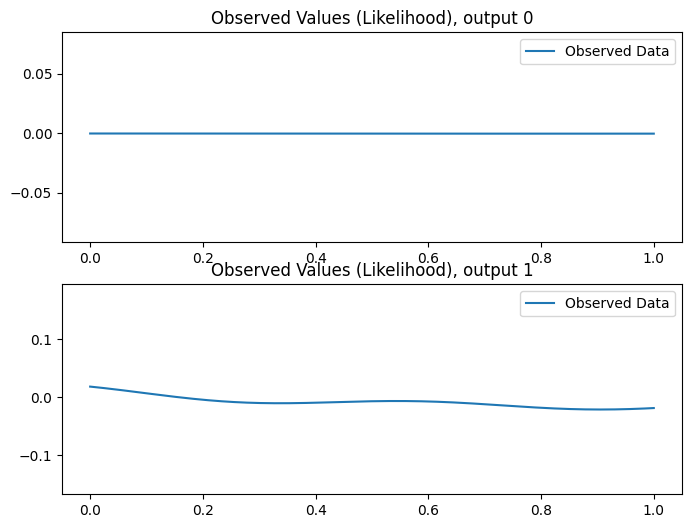

In [21]:
gp_derivative_grid_data = gp_derivative_data_from_model_and_path(gp_model, likelihood, x_grid, num_samples=0)
fig, ax = plot_gp_data([gp_derivative_grid_data], marker_size_lim=[5, 50], plot_train_data=False)

ax[0].set_ylim(*y_lim_0)
ax[1].set_ylim(*y_lim_1)
plt.draw()

# Residual-Model MPC

In [22]:
from zero_order_gpmpc.residual_model import ResidualModel
class ResidualGPyTorch(ResidualModel):
    def __init__(self, gpytorch_model):
        self.gp_model = gpytorch_model
        if gp_model.train_inputs[0].device.type == "cuda":
            self.to_tensor = lambda X: torch.Tensor(X).cuda()
            self.to_numpy = lambda T: T.cpu().numpy()
        else:
            self.to_tensor = lambda X: torch.Tensor(X)
            self.to_numpy = lambda T: T.numpy()
        
        if torch.cuda.is_available():
            self.cuda_is_available = True
        else:
            self.cuda_is_available = False

        def mean_fun_sum(y):
            with gpytorch.settings.fast_pred_var():
                return gp_model(y).mean.sum(dim=0)
        
        self._mean_fun_sum = mean_fun_sum

    def evaluate(self,y):
        with gpytorch.settings.fast_pred_var():
            y_tensor = torch.autograd.Variable(self.to_tensor(y), requires_grad=False)
            with torch.no_grad():
                self.predictions = gp_model(y_tensor)
        return self.to_numpy(self.predictions.mean)

    def jacobian(self,y):
        with gpytorch.settings.fast_pred_var():
            y_tensor = torch.autograd.Variable(self.to_tensor(y), requires_grad=True)
            mean_dy = torch.autograd.functional.jacobian(
                self._mean_fun_sum, 
                y_tensor
            )
        return self.to_numpy(mean_dy)

    def value_and_jacobian(self,y):
        with gpytorch.settings.fast_pred_var():
            y_tensor = torch.autograd.Variable(self.to_tensor(y), requires_grad=True)
            with torch.no_grad():
                self.predictions = gp_model(y_tensor)
            mean_dy = torch.autograd.functional.jacobian(
                self._mean_fun_sum, 
                y_tensor
            )
        
        self.current_mean = self.to_numpy(self.predictions.mean)
        self.current_variance = self.to_numpy(self.predictions.variance)
        self.current_mean_dy = self.to_numpy(mean_dy)
            
        return self.current_mean, self.current_mean_dy

In [23]:
residual_model = ResidualGPyTorch(gp_model)

In [24]:
residual_model.evaluate(x_plot_waypts[0:3,:])

array([[ 0.00196016,  0.01692964],
       [ 0.0019141 , -0.02114403],
       [ 0.00184969, -0.06757671]], dtype=float32)

In [25]:
residual_model.jacobian(x_plot_waypts[0:3,:])

array([[[ 1.51053580e-04,  8.70269068e-05, -2.51301186e-04],
        [ 1.57138755e-04,  1.04873274e-04, -2.54412473e-04],
        [ 1.65801815e-04,  1.22410405e-04, -2.57598644e-04]],

       [[ 2.09472537e-01,  5.45822717e-02,  2.27342639e-02],
        [ 2.01262981e-01,  6.18653968e-02,  2.64177751e-02],
        [ 1.66314438e-01,  4.33820747e-02,  2.83341985e-02]]],
      dtype=float32)

In [26]:
residual_model.value_and_jacobian(x_plot_waypts[0:3,:])

(array([[ 0.00196016,  0.01692964],
        [ 0.0019141 , -0.02114403],
        [ 0.00184969, -0.06757671]], dtype=float32),
 array([[[ 1.51053580e-04,  8.70269068e-05, -2.51301186e-04],
         [ 1.57138755e-04,  1.04873274e-04, -2.54412473e-04],
         [ 1.65801815e-04,  1.22410405e-04, -2.57598644e-04]],
 
        [[ 2.09472537e-01,  5.45822717e-02,  2.27342639e-02],
         [ 2.01262981e-01,  6.18653968e-02,  2.64177751e-02],
         [ 1.66314438e-01,  4.33820747e-02,  2.83341985e-02]]],
       dtype=float32))

In [27]:
residual_mpc = ZeroOrderGPMPC(
    ocp_init,
    sim,
    prob_x, Sigma_x0, Sigma_W,
    h_tightening_idx=[0],
    gp_model=residual_model,
    use_cython=False,
    path_json_ocp="residual_mpc_ocp_solver_config.json",
    path_json_sim="residual_mpc_sim_solver_config.json",
    build_c_code=True
)

rm -f libacados_ocp_solver_linear_model_with_params_nx2_nu1_np0.so
rm -f linear_model_with_params_nx2_nu1_np0_constraints/linear_model_with_params_nx2_nu1_np0_constr_h_fun_jac_uxt_zt.o linear_model_with_params_nx2_nu1_np0_constraints/linear_model_with_params_nx2_nu1_np0_constr_h_fun.o custom_update_function_gpzoro.o acados_solver_linear_model_with_params_nx2_nu1_np0.o
cc -fPIC -std=c99   -O2 -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include/acados -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include/blasfeo/include -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include/hpipm/include  -c -o linear_model_with_params_nx2_nu1_np0_constraints/linear_model_with_params_nx2_nu1_np0_constr_h_fun_jac_uxt_zt.o linear_model_with_params_nx2_nu1_np0_constraints/linear_model_with_params_nx2_nu1_np0_constr_h_fun_jac_uxt_zt.c
cc -fPIC -std=c99   -O2 -I/home/amon/Repositories/zero-order-gp-mpc-githu

In [28]:
for i in range(N):
    residual_mpc.ocp_solver.set(i, "x",X_init[i,:])
    residual_mpc.ocp_solver.set(i, "u",U_init[i,:])
residual_mpc.ocp_solver.set(N, "x",X_init[N,:])

residual_mpc.solve()
X_res,U_res = residual_mpc.get_solution()

residuals after  0 SQP_RTI iterations:
 [2.61799388e+00 8.74780330e-02 7.31909996e-01 1.00000314e-10]


residuals after  1 SQP_RTI iterations:
 [3.93273749e-01 2.78393227e-02 8.68521244e-01 1.00000314e-10]
residuals after  2 SQP_RTI iterations:
 [1.27374146e-01 3.60515704e-02 7.74983944e-01 1.00000314e-10]
residuals after  3 SQP_RTI iterations:
 [9.89735199e-02 2.07278972e-02 6.36628104e-01 1.00000314e-10]
residuals after  4 SQP_RTI iterations:
 [1.07450593e-01 1.92617658e-02 6.70368619e-01 1.00000314e-10]
residuals after  5 SQP_RTI iterations:
 [1.15752881e-01 2.47335150e-02 7.26267789e-01 1.00000314e-10]
residuals after  6 SQP_RTI iterations:
 [1.16427474e-01 2.53314660e-02 7.21445842e-01 1.00000314e-10]
residuals after  7 SQP_RTI iterations:
 [1.15394298e-01 2.97559873e-02 7.11529909e-01 1.00000314e-10]
residuals after  8 SQP_RTI iterations:
 [1.21114130e-01 2.43415715e-02 7.15708766e-01 1.00000314e-10]
residuals after  9 SQP_RTI iterations:
 [1.20071397e-01 3.28822745e-02 7.21433033e-01 1.00000314e-10]
residuals after  10 SQP_RTI iterations:
 [1.24571565e-01 2.50836144e-02 7.21299371

In [29]:
X_res_sim = np.zeros_like(X_res)
X_res_sim[0,:] = x0
for i in range(N):
    acados_integrator_actual.set("x", X_res_sim[i,:])
    acados_integrator_actual.set("u", U_res[i,:])
    acados_integrator_actual.solve()
    X_res_sim[i+1,:] = acados_integrator_actual.get("x")

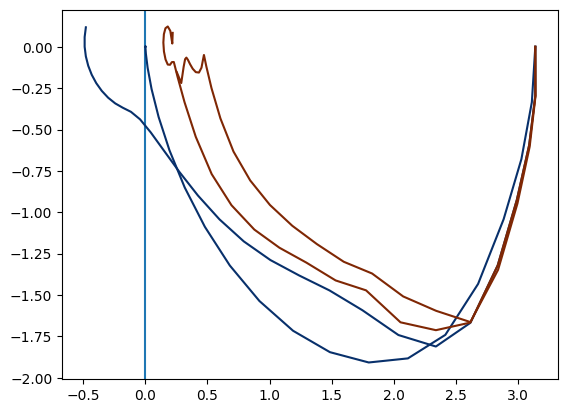

In [30]:
lb_theta = -ocp_init.constraints.lh[0]
fig, ax = base_plot(lb_theta=lb_theta)

plot_data_res = EllipsoidTubeData2D(
    center_data = X_res,
    ellipsoid_data = None
)
plot_data_res_sim = EllipsoidTubeData2D(
    center_data = X_res_sim,
    ellipsoid_data = None
)
add_plot_trajectory(ax, plot_data_nom, prob_tighten=None, color_fun=plt.cm.Blues)
add_plot_trajectory(ax, plot_data_nom_sim, prob_tighten=None, color_fun=plt.cm.Blues)
add_plot_trajectory(ax, plot_data_res, prob_tighten=None, color_fun=plt.cm.Oranges)
add_plot_trajectory(ax, plot_data_res_sim, prob_tighten=None, color_fun=plt.cm.Oranges)

# Zero-Order GP-MPC

We can add the GP model to the solver by simply adding it as an argument to the `ZoroAcados` function. Therefore we copy (important!) the robustified controller and then instantiate another solver object.

### Custom Update version

In [31]:
# delete c_generated_code folder to avoid reusing old files by accident...
import shutil
shutil.rmtree("c_generated_code")

In [32]:
# # we use both-sided bounds again, specify which bound to be tightened using according index
# ocp_cupdate = export_ocp_nominal(N,T,only_lower_bounds=False)
# we use one-sided bounds since we just want to tighten upper bound
ocp_cupdate = export_ocp_nominal(N,T,only_lower_bounds=True,model_name='simplependulum_ode_cupdate')

# tighten constraints
idh_tight = np.array([0]) # lower on theta (theta >= 0)

# integrator for nominal model
sim_cupdate = AcadosSim()

sim_cupdate.model = ocp_cupdate.model
sim_cupdate.parameter_values = ocp_cupdate.parameter_values
for opt_name in dir(ocp_cupdate.solver_options):
    if opt_name in dir(sim.solver_options) and re.search(r"__.*?__", opt_name) is None:
        set_value = getattr(ocp_cupdate.solver_options, opt_name)
        if opt_name == "sim_method_jac_reuse" and isinstance(set_value, list):
            set_value = int(set_value[0])

        print(f"Setting {opt_name} to {set_value}")
        setattr(sim.solver_options, opt_name, set_value)

# set prediction horizon
sim_cupdate.solver_options.T = dT

# acados_ocp_solver = AcadosOcpSolver(ocp_cupdate, json_file = 'acados_ocp_' + model.name + '.json')
acados_integrator_cupdate = AcadosSimSolver(sim_cupdate, json_file = 'acados_sim_' + sim_cupdate.model.name + '_cupdate.json')

Setting collocation_type to GAUSS_LEGENDRE
Setting ext_fun_compile_flags to -O2
Setting integrator_type to ERK
Setting sim_method_jac_reuse to 0
cc -fPIC -std=c99   -O2 -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include/acados -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include/blasfeo/include -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include/hpipm/include  -c -o acados_sim_solver_simplependulum_ode_cupdate.o acados_sim_solver_simplependulum_ode_cupdate.c
cc -fPIC -std=c99   -O2 -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include/acados -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include/blasfeo/include -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include/hpipm/include  -c -o simplependulum_ode_cupdate_model/simplependulum_ode_cupdate_expl_ode_fun.o simplependulum_ode_cup

In [38]:
# %aimport zero_order_gpmpc
# import importlib
# importlib.reload(zero_order_gpmpc)
# from zero_order_gpmpc import ZoroAcadosCustomUpdate
# satisfaction probability for chance constraints

zoro_solver_cupdate = zero_order_gpmpc.ZoroAcadosCustomUpdate(
    ocp_cupdate, sim_cupdate, prob_x, Sigma_x0, Sigma_W, 
    h_tightening_idx=idh_tight, 
    gp_model=gp_model,
    use_cython=False,
    path_json_ocp="zoro_ocp_solver_config_cupdate.json",
    path_json_sim="zoro_sim_solver_config_cupdate.json",
)   

for i in range(N):
    zoro_solver_cupdate.ocp_solver.set(i, "x",X_init[i,:])
    zoro_solver_cupdate.ocp_solver.set(i, "u",U_init[i,:])
zoro_solver_cupdate.ocp_solver.set(N, "x",X_init[N,:])

zoro_solver_cupdate.solve()
X_cup,U_cup,P_cup = zoro_solver_cupdate.get_solution()

rm -f libacados_ocp_solver_linear_model_with_params_nx2_nu1_np0.so
rm -f linear_model_with_params_nx2_nu1_np0_constraints/linear_model_with_params_nx2_nu1_np0_constr_h_fun_jac_uxt_zt.o linear_model_with_params_nx2_nu1_np0_constraints/linear_model_with_params_nx2_nu1_np0_constr_h_fun.o custom_update_function_gpzoro.o acados_solver_linear_model_with_params_nx2_nu1_np0.o
cc -fPIC -std=c99   -O2 -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include/acados -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include/blasfeo/include -I/home/amon/Repositories/zero-order-gp-mpc-github/acados/include/hpipm/include  -c -o linear_model_with_params_nx2_nu1_np0_constraints/linear_model_with_params_nx2_nu1_np0_constr_h_fun_jac_uxt_zt.o linear_model_with_params_nx2_nu1_np0_constraints/linear_model_with_params_nx2_nu1_np0_constr_h_fun_jac_uxt_zt.c
cc -fPIC -std=c99   -O2 -I/home/amon/Repositories/zero-order-gp-mpc-githu

### Custom update (with GP) vs. Residual GP -> the same!

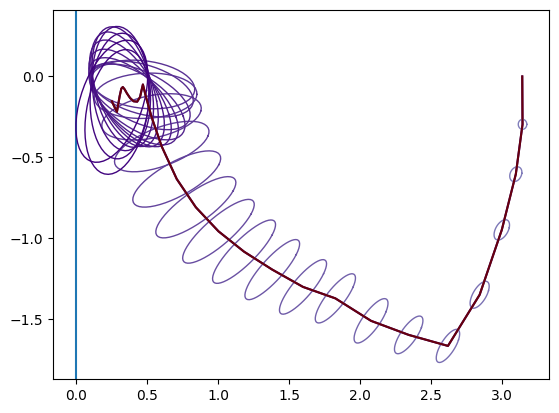

In [45]:
fig, ax = base_plot(lb_theta=lb_theta)

plot_data_gp_cupdate = EllipsoidTubeData2D(
    center_data = X_cup,
    ellipsoid_data = np.array(P_cup)
    # ellipsoid_data = None
)
add_plot_trajectory(ax, plot_data_gp_cupdate, color_fun=plt.cm.Purples)
add_plot_trajectory(ax, plot_data_res, color_fun=plt.cm.Reds)